In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from collections import Counter

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [5]:
from scipy import stats
from scipy.stats import norm, gamma, linregress, skew
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, confusion_matrix, silhouette_score, silhouette_samples

In [6]:
def dump_pickle(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()

def load_pickle(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

In [7]:
sns.set()

## Data Prep

### Read Synergy + Proballers Data

In [131]:
df = pd.read_csv('eurocup_offense_plus_pb.csv')
df.shape

(1170, 84)

In [132]:
mp_filter = df['Poss_est'] >= 300
df = df[mp_filter]
df.shape

(816, 84)

In [133]:
df['avg_eff'] = df['Eff'] / df['GP_y']

In [134]:
def adjust_height(s):
    m, cm = s.split('m')
    return int(m) * 100 + int(cm) 

In [135]:
df['Height'] = df['Height'].apply(adjust_height)

## Clustering

### Functions

In [136]:
def plot_pca_explained_var(x):
    ev_list = []
    c_list = list(range(2, 12))
    for c in c_list:
        pca = PCA(n_components=c)
        ev_list.append(np.sum(pca.fit(x).explained_variance_ratio_))
    
    # Plot
    plt.plot(c_list, ev_list)
    plt.hlines(0.95, 2, 11, color='red', linestyle='--')
    plt.xlabel('Number of Components (c)')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Results')

In [137]:
def plot_silhouette_score(x):
    avg_ss_list = []
    k_list = list(range(2, 16))
    for k in k_list:
        sc = SpectralClustering(n_clusters=k, 
                                affinity='nearest_neighbors', 
                                random_state=42)
        cluster_labels = sc.fit(x).labels_
        avg_silhouette_score = silhouette_score(x, cluster_labels)
        avg_ss_list.append(avg_silhouette_score)

    # Plot
    # Plot the elbow
    plt.plot(k_list, avg_ss_list, 'bx-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.title('The Silhouette Score Method Showing the Optimal k')

### Define Weight Columns

In [138]:
playtypes = ['Isolation', 'P&R Ball Handler', 'Post-Up', 
             'P&R Roll Man', 'Spot Up', 'Off Screen', 
             'Hand Off', 'Cut', 
             'Offensive Rebounds', 
             'Transition']
playtype_weights = [f'{playtype}_Poss%'
                    for playtype in playtypes]

In [139]:
situations = ['Pick and Rolls Including Passes',
              'Isolations Including Passes',
              'Post-Ups Including Passes']
situation_weights = [f'{situation}_On_Court%'
                     for situation in situations]

In [140]:
shottypes = ['Catch and Shoot', 
             'At Rim',
             'Long (3 point jump shots)',
             'All Jump Shots off the Dribble'
            ]
shottype_weights = [f'{shottype}_FGA%' 
                    for shottype in shottypes]

In [141]:
weights = playtype_weights + shottype_weights + situation_weights 
weights

['Isolation_Poss%',
 'P&R Ball Handler_Poss%',
 'Post-Up_Poss%',
 'P&R Roll Man_Poss%',
 'Spot Up_Poss%',
 'Off Screen_Poss%',
 'Hand Off_Poss%',
 'Cut_Poss%',
 'Offensive Rebounds_Poss%',
 'Transition_Poss%',
 'Catch and Shoot_FGA%',
 'At Rim_FGA%',
 'Long (3 point jump shots)_FGA%',
 'All Jump Shots off the Dribble_FGA%',
 'Pick and Rolls Including Passes_On_Court%',
 'Isolations Including Passes_On_Court%',
 'Post-Ups Including Passes_On_Court%']

### Check Correlations Among Weights

Text(0.5, 1.0, 'Correlations Among Weights in EuroCup (2018-2022)')

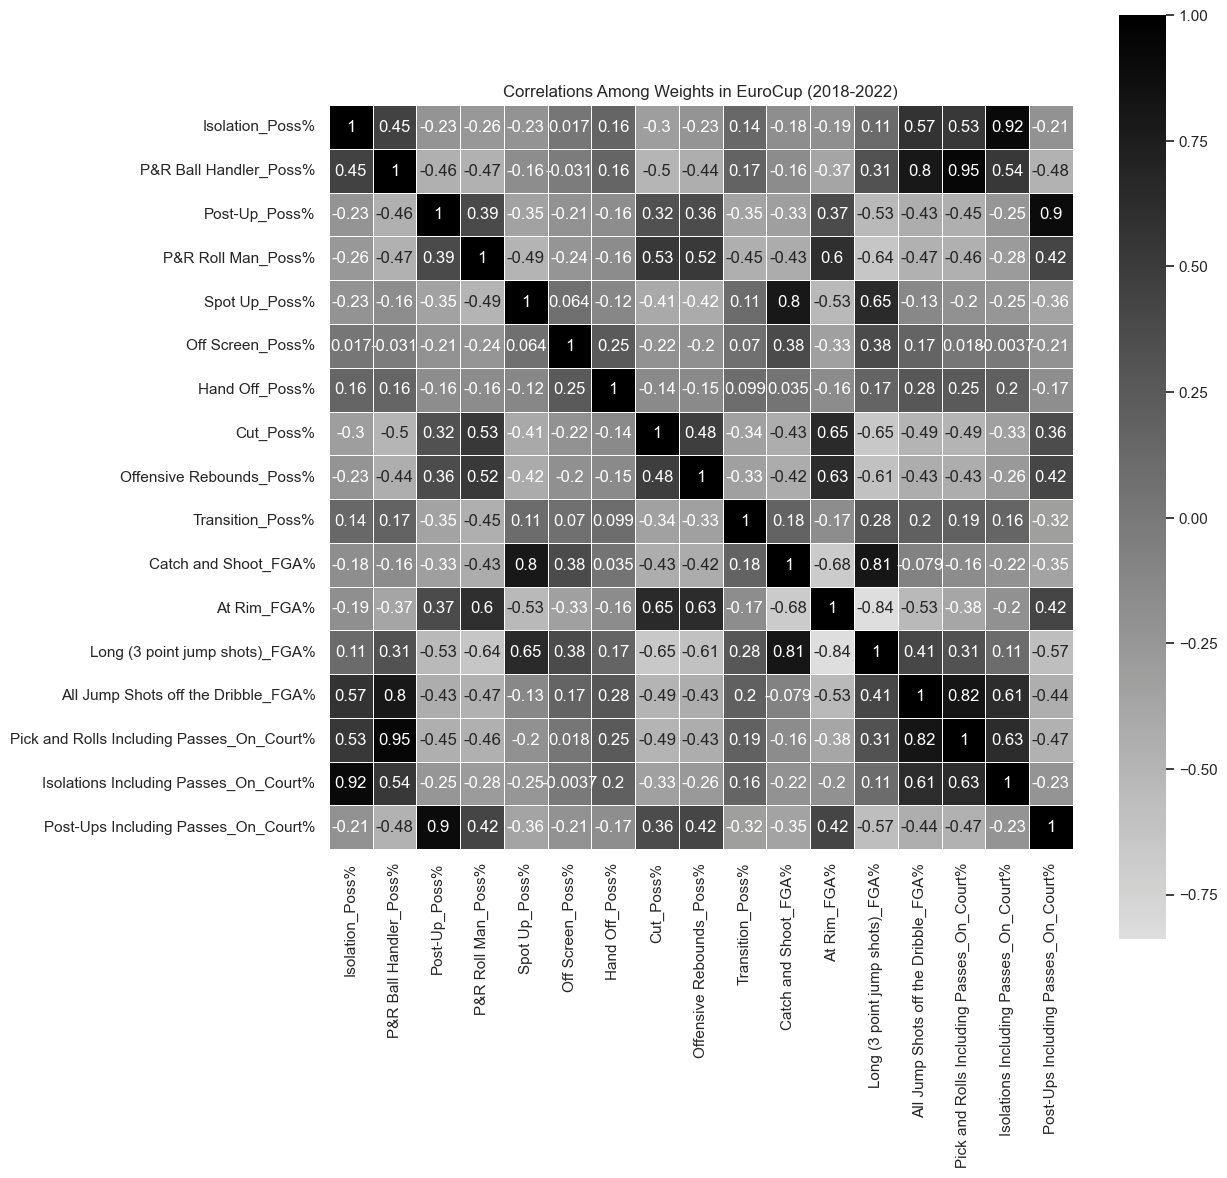

In [142]:
figsize(12, 8)
corr = df[weights].corr()
f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.light_palette('black', as_cmap=True)
sns.heatmap(corr, 
            cmap=cmap, vmax=None, center=0,
            square=True, annot=True, linewidths=.5)
plt.title('Correlations Among Weights in EuroCup (2018-2022)')

### Reduce Dimensions with PCA

In [143]:
X = df[weights].copy()

Determine how many components reduce down to via PCA

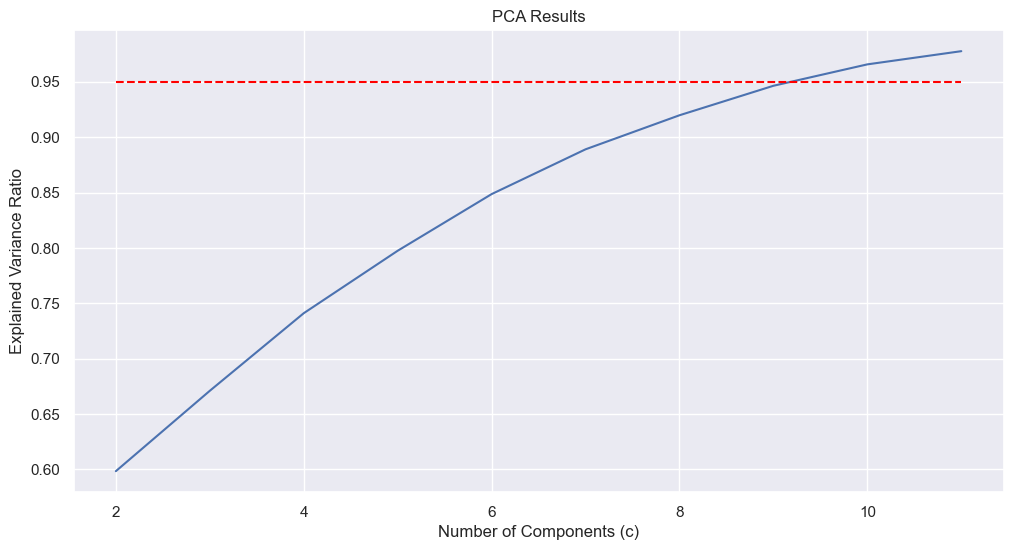

In [144]:
figsize(12, 6)
pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
# pre_pca_pipe = StandardScaler()
plot_pca_explained_var(pre_pca_pipe.fit_transform(X))

Choosse 9

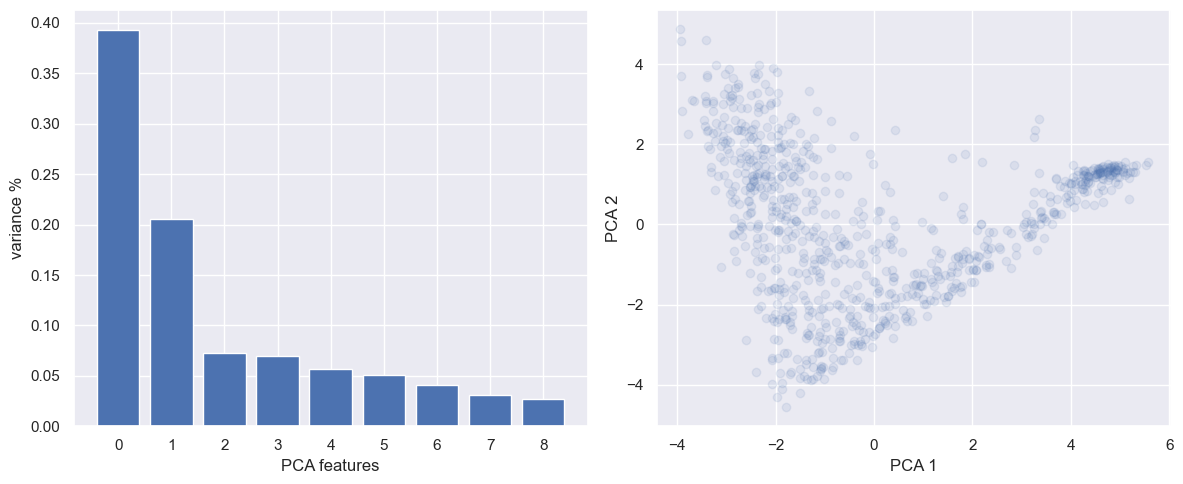

In [145]:
n_components = 9

pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
pca = PCA(n_components=n_components)
pca.fit(pre_pca_pipe.fit_transform(X))
pca_components = pca.transform(pre_pca_pipe.fit_transform(X))

figsize(12, 5)
plt.subplot(1, 2, 1)
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(range(pca.n_components_))

plt.subplot(1, 2, 2)
plt.scatter(pca_components[:, 0], pca_components[:, 1], alpha=.1)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.tight_layout()

In [146]:
pre_cluster_scaler = StandardScaler()
X_transformed = pre_cluster_scaler.fit_transform(pca_components)

### Choose Optimal K

Determine # of clusters using silhouette score method

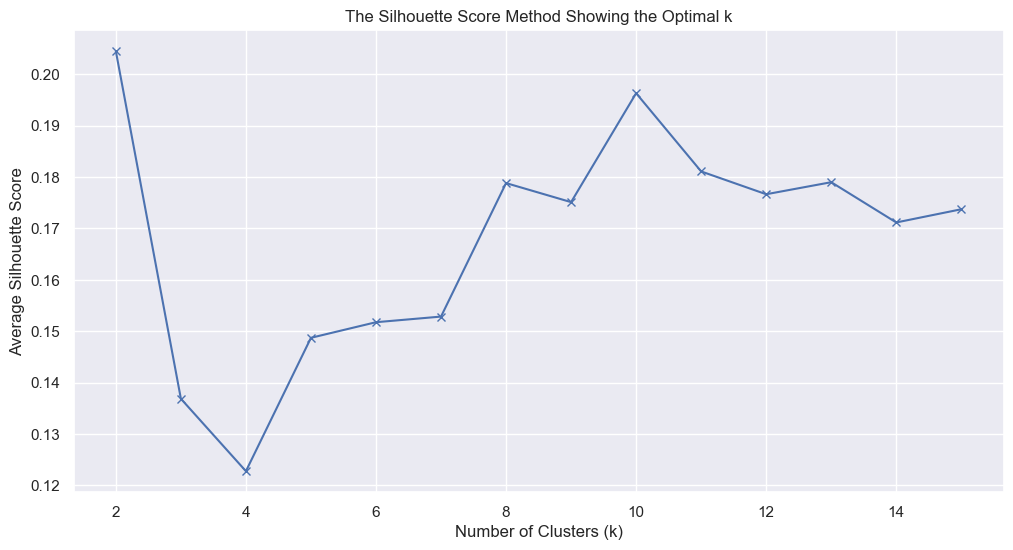

In [147]:
figsize(12, 6)
plot_silhouette_score(X_transformed)

### Clustering

In [148]:
# Choose k = 10
n_clusters = 10

sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors', 
                        random_state=42)
sc.fit(X_transformed)
df['player_cluster'] = sc.labels_
df['silhouette_coefficient'] = silhouette_samples(X_transformed, 
                                                  df['player_cluster'])
df.groupby('player_cluster').count()['Player']

player_cluster
0     50
1     77
2     75
3     56
4    157
5     32
6     44
7     68
8    108
9    149
Name: Player, dtype: int64

## Results

### Functions

In [149]:
def plot_cluster_res_2d(df, cluster_col, col1, col2, cluster_dict):
    clusters = list(set(df[cluster_col]))
    for cluster in clusters:
        cluster_cond = df[cluster_col] == cluster
        x = df[cluster_cond][col1].values * 100
        y = df[cluster_cond][col2].values * 100
        plt.scatter(x, y, 
                    label=f'Cluster {cluster}: {cluster_dict[cluster]}', 
                    alpha=0.3)
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.legend()

In [150]:
def show_cluster_res(df, cluster_col, weights=weights):
    cluster_res = df.groupby(cluster_col)[['avg_eff'] + weights]\
                    .mean().sort_values('avg_eff', ascending=False)
    cluster_cnt = Counter(df[cluster_col])
    cluster_res['avg_eff'] = cluster_res['avg_eff'].apply(lambda x: f'{x:.2f}')
    for col in cluster_res.columns:
        if '%' in col or 'Rt' in col:
            cluster_res[col] = cluster_res[col].apply(lambda x: f'{x:.2%}')
    cluster_res = cluster_res.reset_index()
    cluster_res['#'] = cluster_res[cluster_col].map(cluster_cnt)
    return cluster_res.T

### Overview

In [151]:
show_cluster_res(df, 'player_cluster')

,0,1,2,3,4,5,6,7,8,9
player_cluster,2,4,8,9,1,7,0,3,6,5
avg_eff,12.01,10.85,10.83,10.62,9.13,8.62,8.46,7.29,6.77,5.80
Isolation_Poss%,7.60%,13.55%,0.00%,0.15%,0.26%,0.00%,0.21%,0.00%,0.00%,0.00%
P&R Ball Handler_Poss%,32.96%,37.14%,0.26%,3.32%,11.59%,46.65%,0.00%,5.90%,55.33%,2.12%
Post-Up_Poss%,0.70%,2.32%,11.99%,24.84%,1.68%,0.00%,12.54%,0.91%,0.00%,0.00%
P&R Roll Man_Poss%,0.00%,1.35%,26.90%,10.12%,0.53%,0.00%,36.54%,1.96%,0.00%,0.00%
Spot Up_Poss%,23.29%,24.96%,13.24%,30.95%,43.86%,31.30%,23.83%,62.45%,44.16%,97.88%
Off Screen_Poss%,9.49%,3.38%,0.00%,0.36%,22.27%,0.39%,0.00%,0.00%,0.32%,0.00%
Hand Off_Poss%,8.61%,0.02%,0.00%,0.00%,0.12%,0.00%,0.00%,0.00%,0.00%,0.00%
Cut_Poss%,1.74%,1.45%,21.83%,14.01%,3.02%,0.29%,26.25%,1.08%,0.00%,0.00%


- Ballhandler: 2 & 4 & 7 & 6
- Big: 8 & 9 & 0 
- Wing: 1 & 5

In [152]:
cluster_dict = {2: 'Ballhandler', 4: 'Ballhandler',
                7: 'Ballhandler', 6: 'Ballhandler',
                8: 'Big', 9: 'Big', 0: 'Big',
                1: 'Wing', 3: 'Wing', 5: 'Wing'}

In [153]:
def color_cluster(val, cluster_dict=cluster_dict):
    if cluster_dict[val] == 'Ballhandler':
        return '#AB3B3A'
    elif cluster_dict[val] == 'Wing':
        return '#2E5C6E'
    elif cluster_dict[val] == 'Big':
        return '#F7D94C'

In [154]:
def color_cluster_pandas(val, cluster_dict=cluster_dict):
    if val in cluster_dict.keys():
        color = color_cluster(val, cluster_dict=cluster_dict)
    else:
        color = 'white'
    return f'background-color: {color}' 

In [155]:
show_cluster_res(df, 'player_cluster')\
.style.applymap(color_cluster_pandas)

,0,1,2,3,4,5,6,7,8,9
player_cluster,2,4,8,9,1,7,0,3,6,5
avg_eff,12.01,10.85,10.83,10.62,9.13,8.62,8.46,7.29,6.77,5.80
Isolation_Poss%,7.60%,13.55%,0.00%,0.15%,0.26%,0.00%,0.21%,0.00%,0.00%,0.00%
P&R Ball Handler_Poss%,32.96%,37.14%,0.26%,3.32%,11.59%,46.65%,0.00%,5.90%,55.33%,2.12%
Post-Up_Poss%,0.70%,2.32%,11.99%,24.84%,1.68%,0.00%,12.54%,0.91%,0.00%,0.00%
P&R Roll Man_Poss%,0.00%,1.35%,26.90%,10.12%,0.53%,0.00%,36.54%,1.96%,0.00%,0.00%
Spot Up_Poss%,23.29%,24.96%,13.24%,30.95%,43.86%,31.30%,23.83%,62.45%,44.16%,97.88%
Off Screen_Poss%,9.49%,3.38%,0.00%,0.36%,22.27%,0.39%,0.00%,0.00%,0.32%,0.00%
Hand Off_Poss%,8.61%,0.02%,0.00%,0.00%,0.12%,0.00%,0.00%,0.00%,0.00%,0.00%
Cut_Poss%,1.74%,1.45%,21.83%,14.01%,3.02%,0.29%,26.25%,1.08%,0.00%,0.00%


### Observations

In [156]:
# figsize(12, 8)
# plt.subplot(1, 2, 1)
# plot_cluster_res_2d(df, 
#                     cluster_col='player_cluster', 
#                     col1='P&R Ball Handler_Poss%', 
#                     col2='P&R Roll Man_Poss%',
#                     cluster_dict=cluster_dict)
# plt.subplot(1, 2, 2)
# plot_cluster_res_2d(df, 
#                     cluster_col='player_cluster', 
#                     col1='Isolation_Poss%', 
#                     col2='Post-Up_Poss%',
#                     cluster_dict=cluster_dict)

In [157]:
# figsize(12, 8)
# plt.subplot(1, 2, 1)
# plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
#                                                   for cluster in cluster_dict.keys() 
#                                                   if cluster_dict[cluster] == 'Big'])], 
#                     cluster_col='player_cluster', 
#                     col1='P&R Roll Man_Poss%', 
#                     col2='Post-Up_Poss%',
#                     cluster_dict=cluster_dict)
# plt.subplot(1, 2, 2)
# plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
#                                                   for cluster in cluster_dict.keys() 
#                                                   if cluster_dict[cluster] == 'Big'])], 
#                     cluster_col='player_cluster', 
#                     col1='P&R Roll Man_Poss%', 
#                     col2='Isolation_Poss%',
#                     cluster_dict=cluster_dict)
# plt.tight_layout()

In [158]:
# figsize(12, 8)
# plt.subplot(1, 2, 1)
# plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
#                                                   for cluster in cluster_dict.keys() 
#                                                   if cluster_dict[cluster] != 'Big'])], 
#                     cluster_col='player_cluster', 
#                     col1='P&R Ball Handler_Poss%', 
#                     col2='Spot Up_Poss%',
#                     cluster_dict=cluster_dict)
# plt.subplot(1, 2, 2)
# plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
#                                                   for cluster in cluster_dict.keys() 
#                                                   if cluster_dict[cluster] != 'Big'])], 
#                     cluster_col='player_cluster', 
#                     col1='P&R Ball Handler_Poss%', 
#                     col2='Isolation_Poss%',
#                     cluster_dict=cluster_dict)
# plt.tight_layout()

### Distributions

In [159]:
cluster_dict

{2: 'Ballhandler',
 4: 'Ballhandler',
 7: 'Ballhandler',
 6: 'Ballhandler',
 8: 'Big',
 9: 'Big',
 0: 'Big',
 1: 'Wing',
 3: 'Wing',
 5: 'Wing'}

In [160]:
cluster_order = [2, 4, 7, 6, 1, 3, 5, 8, 9, 0]

Height & EFF

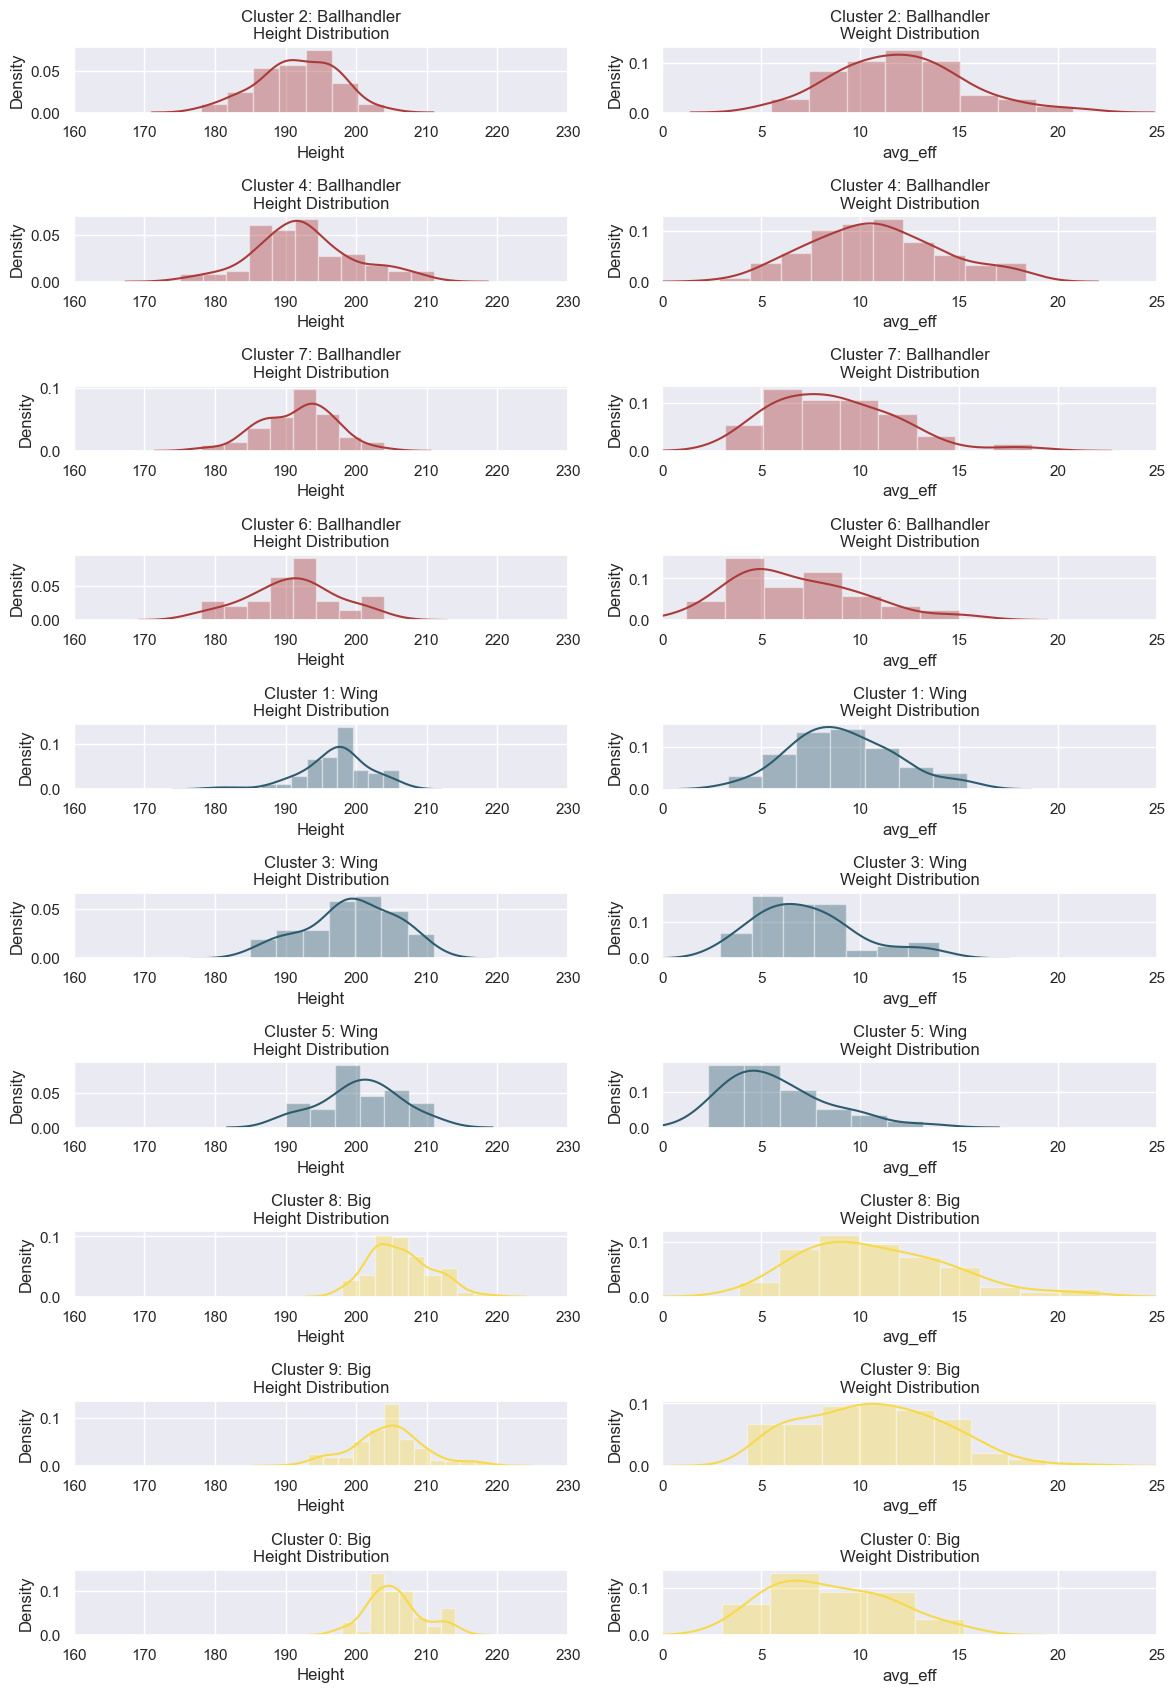

In [162]:
figsize(12, 20)
for idx, cluster in enumerate(cluster_order, 0):
    color = color_cluster(cluster)
    plt.subplot(12, 2, idx*2+1)
    sns.distplot(df[df['player_cluster'] == cluster]['Height'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nHeight Distribution')
    plt.xlim(160, 230)
    plt.subplot(12, 2, idx*2+2)
    sns.distplot(df[df['player_cluster'] == cluster]['avg_eff'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nWeight Distribution')
    plt.xlim(0, 25)
plt.tight_layout()

### Top & Bottom Players by Cluster

In [168]:
def display_cluster_players(df, cluster_col, cluster_label):
    cols = ['Player', 'Season', 'Team', 'MIN', 'avg_eff']
    best_10 = df[df[cluster_col] == cluster_label].sort_values('avg_eff', ascending=False)\
                                                  .head(10)[cols]\
                                                  .rename(columns={'Player': 'Best 10 Players'})\
                                                  .reset_index().drop('index', axis=1)
    worst_10 = df[df[cluster_col] == cluster_label].sort_values('avg_eff')\
                                                   .head(10)[cols]\
                                                   .rename(columns={'Player': 'Worst 10 Players'})\
                                                   .reset_index().drop('index', axis=1)
    return pd.concat([best_10, worst_10], axis=1)

Ballhandlers

In [170]:
c = 2
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 75


,Best 10 Players,Season,Team,MIN,avg_eff,Worst 10 Players,Season,Team,MIN,avg_eff
0,Erick Green,2020-2021,Bahcesehir Koleji Istanbul,283,20.777778,Fedor Zugic,2021-2022,Ratiopharm Ulm,315,5.500000
1,Errick McCollum,2021-2022,Lokomotiv Kuban,359,20.500000,Jakub Karolak,2021-2022,WKS Slask Wroclaw,427,5.722222
2,Kendrick Perry,2020-2021,Cedevita Olimpija Ljubljana,439,18.375000,Karim Jallow,2021-2022,Ratiopharm Ulm,392,6.055556
3,Semaj Christon,2019-2020,Limoges CSP,227,17.714286,Deividas Sirvydis,2019-2020,BC Rytas Vilnius,240,6.187500
4,Peyton Siva,2018-2019,ALBA Berlin,375,17.714286,Kodi Justice,2021-2022,WKS Slask Wroclaw,459,7.722222
5,Milos Teodosic,2019-2020,Virtus Segafredo Bologna,388,17.133333,Victor Sanders,2020-2021,Dolomiti Energia Trento,373,7.750000
6,Jaka Blazic,2020-2021,Cedevita Olimpija Ljubljana,493,16.625000,Tomas Dimsa,2020-2021,Herbalife Gran Canaria,416,7.947368
7,Javonte Green,2018-2019,Ratiopharm Ulm,372,16.000000,Josh Bostic,2019-2020,Asseco Arka Gdynia,264,8.300000
8,Milos Teodosic,2020-2021,Virtus Segafredo Bologna,483,15.722222,Klemen Prepelic,2021-2022,Valencia Basket,321,8.500000
9,Jamar Smith,2020-2021,Unics Kazan,557,15.571429,Zoran Dragic,2019-2020,Ratiopharm Ulm,174,8.571429


In [171]:
c = 4
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 157


,Best 10 Players,Season,Team,MIN,avg_eff,Worst 10 Players,Season,Team,MIN,avg_eff
0,Semaj Christon,2021-2022,Ratiopharm Ulm,588,18.388889,Lukasz Kolenda,2021-2022,WKS Slask Wroclaw,331,2.875000
1,Isaia Cordinier,2020-2021,JSF Nanterre 92,435,18.307692,Anton Ponkrashov,2018-2019,Unics Kazan,277,4.350000
2,Diante Garrett,2018-2019,Tofas Bursa,327,18.100000,Mindaugas Girdziunas,2019-2020,BC Rytas Vilnius,219,4.437500
3,Sammy Mejia,2018-2019,Tofas Bursa,285,17.900000,Marko Simonovic,2018-2019,Zenit Saint Petersburg,264,5.200000
4,Alex Hamilton,2019-2020,Maccabi ILAND.TV Rishon Lezion,323,17.800000,Paulius Valinskas,2020-2021,Lietkabelis Panevezys,231,5.222222
5,Codi Miller-McIntyre,2019-2020,Cedevita Olimpija Ljubljana,293,17.700000,A.J. Slaughter,2018-2019,LDLC ASVEL Lyon-Villeurbanne,365,5.388889
6,Will Cummings,2021-2022,Metropolitans 92,573,17.650000,Nikos Gkikas,2021-2022,Promitheas Patras,227,5.416667
7,Nigel Hayes,2018-2019,Galatasaray Doga Sigorta,287,17.400000,Victor Sanders,2021-2022,Umana Reyer Venezia,287,5.500000
8,Maik Kotsar,2021-2022,Hamburg Towers,428,17.062500,Berk Ugurlu,2019-2020,Tofas Bursa,311,5.625000
9,Luke Sikma,2018-2019,ALBA Berlin,637,16.625000,Dovydas Giedraitis,2021-2022,Lietkabelis Panevezys,363,5.928571


In [172]:
c = 7
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 68


,Best 10 Players,Season,Team,MIN,avg_eff,Worst 10 Players,Season,Team,MIN,avg_eff
0,Nigel Williams-Goss,2020-2021,Lokomotiv Kuban,173,18.666667,Garai Zeeb,2018-2019,Fraport Skyliners Frankfurt,185,3.153846
1,Darius Thompson,2021-2022,Lokomotiv Kuban,360,17.333333,Fedor Zugic,2020-2021,Buducnost VOLI Podgorica,167,3.583333
2,Vincent Sanford,2019-2020,Limoges CSP,184,14.428571,Petar Popovic,2020-2021,Buducnost VOLI Podgorica,207,4.071429
3,Langston Hall,2019-2020,Promitheas Patras,327,13.615385,Davide Casarin,2020-2021,Umana Reyer Venezia,162,4.400000
4,Tyshawn Taylor,2018-2019,Reale Mutua Torino,189,13.000000,Tommaso Laquintana,2019-2020,Germani Brescia Leonessa,227,4.562500
5,Mantas Kalnietis,2020-2021,Lokomotiv Kuban,502,13.000000,Abdul Gaddy,2021-2022,Promitheas Patras,422,4.722222
6,Stefan Markovic,2019-2020,Virtus Segafredo Bologna,449,12.375000,Dogus Ozdemiroglu,2019-2020,Darussafaka Tekfen Istanbul,249,4.812500
7,Dallas Moore,2019-2020,JSF Nanterre 92,280,12.200000,Luka Asceric,2020-2021,JL Bourg Basket,249,5.357143
8,Ferran Bassas,2020-2021,Joventut Badalona Club,435,12.111111,Per Günther,2020-2021,Ratiopharm Ulm,181,5.400000
9,Dario Brizuela,2020-2021,Unicaja Malaga,308,11.785714,Sergi Garcia,2020-2021,MoraBanc Andorra,249,5.437500


In [173]:
c = 6
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 44


,Best 10 Players,Season,Team,MIN,avg_eff,Worst 10 Players,Season,Team,MIN,avg_eff
0,Vangelis Mantzaris,2020-2021,Promitheas Patras,171,15.000000,Nico Mannion,2021-2022,Virtus Segafredo Bologna,183,1.187500
1,Kenny Chery,2019-2020,JSF Nanterre 92,216,14.750000,Omer Al,2021-2022,Frutti Extra Bursaspor Basketbol,186,2.315789
2,Alberto Diaz,2020-2021,Unicaja Malaga,272,11.636364,Per Günther,2021-2022,Ratiopharm Ulm,220,2.444444
3,Sam van Rossom,2021-2022,Valencia Basket,286,11.428571,Can Korkmaz,2019-2020,Galatasaray Doga Sigorta,164,3.076923
4,Julyan Stone,2019-2020,Umana Reyer Venezia,308,11.071429,Can Ugur Ogut,2021-2022,Turk Telekom Ankara,299,3.444444
5,Kendrick Perry,2021-2022,Buducnost VOLI Podgorica,197,10.875000,Dimitrios Katsivelis,2019-2020,Promitheas Patras,199,3.600000
6,Martin Hermannsson,2021-2022,Valencia Basket,444,10.100000,Joan Sastre,2018-2019,Valencia Basket,218,3.928571
7,Chris Kramer,2018-2019,BC Rytas Vilnius,185,9.875000,Damien Bouquet,2019-2020,JSF Nanterre 92,228,4.200000
8,Luca Vitali,2019-2020,Germani Brescia Leonessa,377,9.733333,Andrea De Nicolao,2021-2022,Umana Reyer Venezia,246,4.200000
9,Baris Ermis,2019-2020,Tofas Bursa,245,9.285714,Sead Sehovic,2020-2021,KK Mornar Bar,202,4.285714


Bigs

In [175]:
c = 8
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 108


,Best 10 Players,Season,Team,MIN,avg_eff,Worst 10 Players,Season,Team,MIN,avg_eff
0,Johnathan Motley,2021-2022,Lokomotiv Kuban,239,22.111111,Maximilian Ladurner,2020-2021,Dolomiti Energia Trento,192,3.875000
1,Alan Williams,2020-2021,Lokomotiv Kuban,215,20.500000,Marco Voeller,2018-2019,Fraport Skyliners Frankfurt,169,4.125000
2,Hassan Martin,2019-2020,Buducnost VOLI Podgorica,236,20.111111,Ilimane Diop,2021-2022,Herbalife Gran Canaria,221,4.277778
3,Dylan Osetkowski,2020-2021,Ratiopharm Ulm,268,19.600000,Eddy Edigin,2021-2022,Hamburg Towers,183,5.411765
4,Artsiom Parakhouski,2018-2019,BC Rytas Vilnius,186,18.125000,Ivan Marinkovic,2020-2021,Cedevita Olimpija Ljubljana,181,5.636364
5,Vince Hunter,2021-2022,Metropolitans 92,502,17.500000,Vincent Kesteloot,2020-2021,Telenet Giants Antwerp,242,5.900000
6,Willie Reed,2020-2021,Buducnost VOLI Podgorica,378,17.000000,Ruben Guerrero,2020-2021,Unicaja Malaga,269,6.000000
7,Mathias Lessort,2021-2022,Partizan NiS Beograd,233,16.400000,Maxime Roos,2021-2022,JL Bourg Basket,273,6.111111
8,Johnny Hamilton,2019-2020,Darussafaka Tekfen Istanbul,417,16.066667,Amedeo Tessitori,2021-2022,Virtus Segafredo Bologna,193,6.166667
9,Uros Lukovic,2018-2019,KK Mornar Bar,217,16.000000,Babatunde Olumuyiwa,2021-2022,MoraBanc Andorra,255,6.266667


In [176]:
c = 9
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 149


,Best 10 Players,Season,Team,MIN,avg_eff,Worst 10 Players,Season,Team,MIN,avg_eff
0,Rasid Mahalbasic,2019-2020,EWE Baskets Oldenburg,382,21.266667,Pep Busquets,2021-2022,Joventut Badalona Club,252,4.277778
1,Jaron Blossomgame,2021-2022,Ratiopharm Ulm,631,19.000000,Amar Alibegovic,2021-2022,Virtus Segafredo Bologna,293,5.000000
2,Vladimir Stimac,2018-2019,Turk Telekom Ankara,243,17.800000,Kim Tillie,2019-2020,AS Monaco Basket,218,5.000000
3,Jalen Reynolds,2018-2019,Zenit Saint Petersburg,388,17.687500,David Moss,2020-2021,Germani Brescia Leonessa,202,5.100000
4,Mouhammadou Jaiteh,2021-2022,Virtus Segafredo Bologna,463,16.904762,Burak Yildizli,2020-2021,Bahcesehir Koleji Istanbul,208,5.125000
5,JaCorey Williams,2020-2021,Dolomiti Energia Trento,358,16.785714,Mario Nakic,2021-2022,MoraBanc Andorra,321,5.142857
6,Devin Williams,2019-2020,Tofas Bursa,399,16.375000,Amine Noua,2021-2022,MoraBanc Andorra,248,5.230769
7,Greg Whittington,2019-2020,Galatasaray Doga Sigorta,280,16.363636,Maik Zirbes,2019-2020,Cedevita Olimpija Ljubljana,157,5.500000
8,Robert Upshaw,2018-2019,Asseco Arka Gdynia,207,16.000000,Cameron Bairstow,2019-2020,BC Rytas Vilnius,204,5.500000
9,Kyle Weems,2018-2019,Tofas Bursa,320,15.700000,Vangelis Mantzaris,2019-2020,Unics Kazan,215,5.500000


In [177]:
c = 0
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 50


,Best 10 Players,Season,Team,MIN,avg_eff,Worst 10 Players,Season,Team,MIN,avg_eff
0,Kenny Kadji,2020-2021,Frutti Extra Bursaspor Basketbol,213,15.222222,Maximilian Ladurner,2021-2022,Dolomiti Energia Trento,206,3.000000
1,Erik Murphy,2018-2019,Fraport Skyliners Frankfurt,254,14.500000,Nacho Llovet,2020-2021,MoraBanc Andorra,221,3.812500
2,Oguz Savas,2020-2021,Frutti Extra Bursaspor Basketbol,183,14.200000,Tim Schneider,2018-2019,ALBA Berlin,260,4.260870
3,Kenny Gabriel,2018-2019,Turk Telekom Ankara,255,13.300000,Ike Udanoh,2019-2020,Umana Reyer Venezia,182,4.266667
4,Drew Gordon,2020-2021,Lokomotiv Kuban,155,12.666667,Dragan Apic,2020-2021,Buducnost VOLI Podgorica,172,4.928571
5,Pierre Pelos,2021-2022,JL Bourg Basket,329,12.250000,Metin Turen,2021-2022,Frutti Extra Bursaspor Basketbol,348,4.950000
6,Josh Owens,2020-2021,Bahcesehir Koleji Istanbul,183,11.857143,Nicolas Bretzel,2021-2022,Ratiopharm Ulm,184,5.250000
7,Alan Williams,2021-2022,Lokomotiv Kuban,179,11.777778,Joel Parra,2020-2021,Joventut Badalona Club,251,5.333333
8,Davide Pascolo,2018-2019,Dolomiti Energia Trento,172,11.625000,Johannes Thiemann,2018-2019,ALBA Berlin,241,5.450000
9,Brian Conklin,2019-2020,Limoges CSP,204,11.333333,Oz Blayzer,2019-2020,Maccabi ILAND.TV Rishon Lezion,210,5.600000


Wings

In [179]:
c = 1
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 77


,Best 10 Players,Season,Team,MIN,avg_eff,Worst 10 Players,Season,Team,MIN,avg_eff
0,Rokas Giedraitis,2018-2019,ALBA Berlin,661,15.416667,Fabio Mian,2018-2019,Dolomiti Energia Trento,159,3.300000
1,Sergey Karasev,2018-2019,Zenit Saint Petersburg,243,15.222222,Fabio Mian,2019-2020,Dolomiti Energia Trento,197,4.133333
2,Gediminas Orelik,2021-2022,Lietkabelis Panevezys,431,14.866667,Joshiko Saibou,2018-2019,ALBA Berlin,249,4.562500
3,Josh Bostic,2018-2019,Asseco Arka Gdynia,295,14.500000,Marko Jeremic,2020-2021,KK Mornar Bar,319,4.937500
4,Thomas Scrubb,2020-2021,JL Bourg Basket,313,13.692308,David Jelinek,2020-2021,MoraBanc Andorra,309,5.500000
5,Xabier Lopez-Arostegui,2020-2021,Joventut Badalona Club,402,13.250000,Robin Christen,2021-2022,Hamburg Towers,315,5.647059
6,John Shurna,2021-2022,Herbalife Gran Canaria,368,12.600000,Filip Kruslin,2019-2020,Cedevita Olimpija Ljubljana,180,5.900000
7,Michael Bramos,2019-2020,Umana Reyer Venezia,422,12.125000,Brandon Paul,2021-2022,Joventut Badalona Club,191,5.916667
8,Awudu Abass,2018-2019,Germani Brescia Leonessa,286,12.100000,Nicolas Lang,2019-2020,Limoges CSP,213,6.300000
9,John Shurna,2018-2019,MoraBanc Andorra,504,12.095238,Michele Vitali,2018-2019,MoraBanc Andorra,431,6.550000


In [180]:
c = 3
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 56


,Best 10 Players,Season,Team,MIN,avg_eff,Worst 10 Players,Season,Team,MIN,avg_eff
0,Derek Willis,2019-2020,Ratiopharm Ulm,195,14.000000,Alen Hodzic,2020-2021,Cedevita Olimpija Ljubljana,182,2.928571
1,Frederic Bourdillon,2019-2020,Maccabi ILAND.TV Rishon Lezion,168,13.333333,Richard Freudenberg,2018-2019,Fraport Skyliners Frankfurt,288,3.062500
2,Jamil Wilson,2018-2019,Reale Mutua Torino,268,13.100000,Luca Conti,2021-2022,Dolomiti Energia Trento,240,3.647059
3,Arnas Butkevicius,2019-2020,BC Rytas Vilnius,428,13.062500,David Cournooh,2019-2020,Virtus Segafredo Bologna,168,3.666667
4,David Dudzinski,2020-2021,Telenet Giants Antwerp,266,11.900000,Kevin McClain,2019-2020,EWE Baskets Oldenburg,162,3.666667
5,Marko Simonovic,2019-2020,Cedevita Olimpija Ljubljana,219,11.200000,Albert Ventura,2021-2022,Joventut Badalona Club,212,4.333333
6,Ivan Ramljak,2021-2022,WKS Slask Wroclaw,403,11.066667,Andres Forray,2021-2022,Dolomiti Energia Trento,263,4.533333
7,Tekele Cotton,2018-2019,Reale Mutua Torino,166,10.000000,Max DiLeo,2021-2022,Hamburg Towers,308,4.722222
8,Oleksandr Lypovyy,2019-2020,Promitheas Patras,387,9.466667,Uros Trifunovic,2021-2022,Partizan NiS Beograd,236,4.846154
9,Vrenz Bleijenbergh,2020-2021,Telenet Giants Antwerp,235,9.200000,Ivan Fevrier,2020-2021,JSF Nanterre 92,269,4.875000


In [181]:
c = 5
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 32


,Best 10 Players,Season,Team,MIN,avg_eff,Worst 10 Players,Season,Team,MIN,avg_eff
0,Metin Turen,2020-2021,Frutti Extra Bursaspor Basketbol,159,13.166667,Andrea Mezzanotte,2019-2020,Dolomiti Energia Trento,263,2.312500
1,Strahinja Micovic,2018-2019,KK Mornar Bar,187,10.333333,Dmitrii Uzinskii,2020-2021,Unics Kazan,274,2.318182
2,Aric Holman,2020-2021,Ratiopharm Ulm,205,9.900000,Dorukhan Engindeniz,2021-2022,Turk Telekom Ankara,203,2.857143
3,Vytenis Lipkevicius,2020-2021,Lietkabelis Panevezys,251,9.500000,Franz Wagner,2018-2019,ALBA Berlin,201,3.227273
4,Brian Sacchetti,2020-2021,Germani Brescia Leonessa,179,9.444444,Landing Sane,2019-2020,AS Monaco Basket,177,3.500000
5,Stanislav Ilnitskiy,2021-2022,Lokomotiv Kuban,226,8.000000,Karsten Tadda,2019-2020,EWE Baskets Oldenburg,329,3.562500
6,Brian Sacchetti,2018-2019,Germani Brescia Leonessa,179,7.500000,Troy Barnies,2020-2021,Lietkabelis Panevezys,173,3.700000
7,Julyan Stone,2021-2022,Umana Reyer Venezia,326,7.375000,Joel Parra,2019-2020,Joventut Badalona Club,170,3.750000
8,Borisa Simanic,2018-2019,Crvena Zvezda mts,184,7.066667,Branko Lazic,2018-2019,Crvena Zvezda mts,195,3.833333
9,Albert Ventura,2020-2021,Joventut Badalona Club,298,6.571429,Steeve Ho You Fat,2021-2022,Metropolitans 92,200,3.944444


In [188]:
df[(df['player_cluster'] == 5) &
   (df['Player'] == 'Metin Turen')]

,Player,Team,Season,GP_x,FGM_x,FGA_x,Catch and Shoot_FGM,Catch and Shoot_FGA,Catch and Shoot_FG%,Catch and Shoot_FGA%,At Rim_FGM,At Rim_FGA,At Rim_FG%,At Rim_FGA%,Long (3 point jump shots)_FGM,Long (3 point jump shots)_FGA,Long (3 point jump shots)_FG%,Long (3 point jump shots)_FGA%,All Jump Shots off the Dribble_FGM,All Jump Shots off the Dribble_FGA,All Jump Shots off the Dribble_FG%,All Jump Shots off the Dribble_FGA%,Isolation_Poss,Isolation_PPP,P&R Ball Handler_Poss,P&R Ball Handler_PPP,Post-Up_Poss,Post-Up_PPP,P&R Roll Man_Poss,P&R Roll Man_PPP,Spot Up_Poss,Spot Up_PPP,Off Screen_Poss,Off Screen_PPP,Hand Off_Poss,Hand Off_PPP,Cut_Poss,Cut_PPP,Offensive Rebounds_Poss,Offensive Rebounds_PPP,Transition_Poss,Transition_PPP,Overall_Poss,Isolation_Poss%,P&R Ball Handler_Poss%,Post-Up_Poss%,P&R Roll Man_Poss%,Spot Up_Poss%,Off Screen_Poss%,Hand Off_Poss%,Cut_Poss%,Offensive Rebounds_Poss%,Transition_Poss%,Pick and Rolls Including Passes_Poss,Isolations Including Passes_Poss,Post-Ups Including Passes_Poss,P&R Ball Handler_End_Rt,Height,Age,Pts,Reb,Ast,GP_y,W-L,MIN,Or,Stl,To,Blk,Fo,Eff,2PM,2PA,3PM,3PA,FGM_y,FGA_y,FTM,FTA,Dr,Poss_est,Pick and Rolls Including Passes_On_Court%,Isolations Including Passes_On_Court%,Post-Ups Including Passes_On_Court%,avg_eff,player_cluster,silhouette_coefficient
835,Metin Turen,Frutti Extra Bursaspor Basketbol,2020-2021,6,21.0,30.0,7.0,11.0,0.636364,0.366667,13.0,16.0,0.8125,0.533333,6.0,11.0,0.545455,0.366667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,1.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206,26.0,57,29,5,6,1-5,159,5,4,8,2,15,79,15,19,6,12,21,31,9,9,24,306.887613,0.0,0.0,0.0,13.166667,5,0.608045


### Edge Cases

In [182]:
temp = df.groupby('Player')['player_cluster'].apply(list).reset_index()
temp['player_cluster_adj'] = temp['player_cluster'].apply(lambda x: [cluster_dict[s] 
                                                                     for s in x])\
                                                   .apply(set)
temp['player_cluster'] = temp['player_cluster'].apply(set)
temp['n_cluster'] = temp['player_cluster_adj'].apply(len)
temp[temp['n_cluster'] == 3]

,Player,player_cluster,player_cluster_adj,n_cluster
149,Dimitrios Agravanis,"{0, 3, 4}","{Wing, Big, Ballhandler}",3


In [183]:
temp[(temp['n_cluster'] == 2) & 
     (temp['player_cluster_adj'] == set(['Ballhandler', 'Big']))]

,Player,player_cluster,player_cluster_adj,n_cluster
108,Damien Bouquet,"{9, 6}","{Big, Ballhandler}",2
109,Damien Inglis,"{9, 4}","{Big, Ballhandler}",2
238,JJ O'Brien,"{9, 4}","{Big, Ballhandler}",2
438,Oriol Pauli,"{9, 7}","{Big, Ballhandler}",2
543,Vangelis Mantzaris,"{9, 6}","{Big, Ballhandler}",2


## Visualization via TSNE

In [184]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.2.0.


Changed in version 1.2: The default value changed to "pca".  
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE

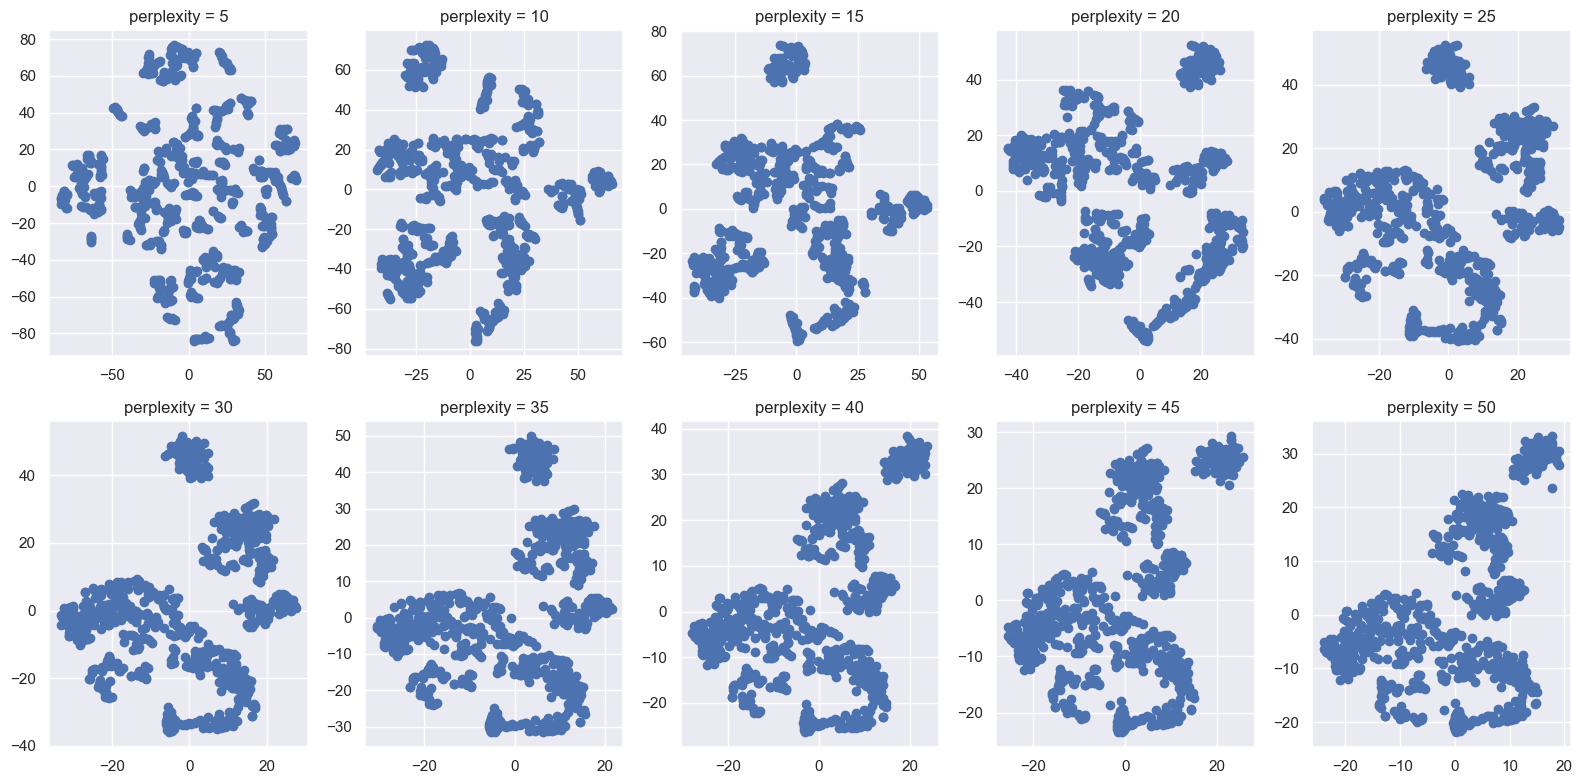

In [185]:
figsize(16, 8)
for i in list(range(1, 11)):
    plt.subplot(2, 5, i)
    perplexity = 5 * i
    tsne = TSNE(perplexity=perplexity, 
                early_exaggeration=4,
                init='random',
                random_state=42)
    X_tsne = tsne.fit_transform(X_transformed)
    plt.scatter(X_tsne[:,0], X_tsne[:, 1])
    plt.title(f'perplexity = {perplexity}')
plt.tight_layout()

In [189]:
perplexity = 25
tsne = TSNE(perplexity=perplexity, 
            early_exaggeration=4,
            init='random',
            random_state=42)
X_tsne = tsne.fit_transform(X_transformed)

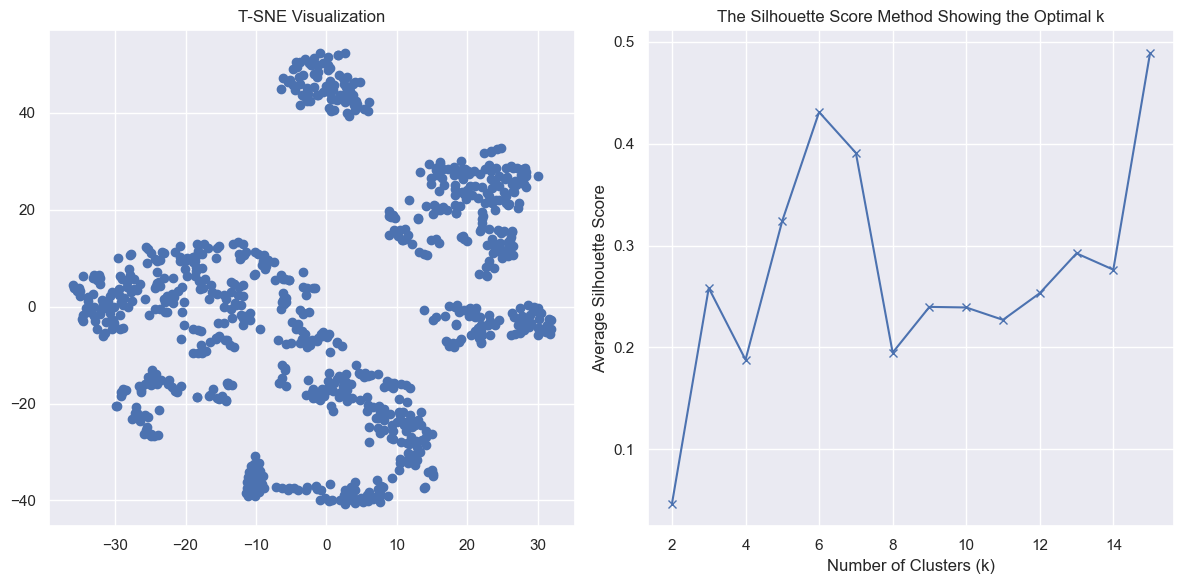

In [190]:
figsize(12, 6)
plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1])
plt.title('T-SNE Visualization')
plt.subplot(1, 2, 2)
plot_silhouette_score(X_tsne)
plt.tight_layout()

In [191]:
df_tsne = df.copy()
n_clusters_tsne = 6

sc_tsne = SpectralClustering(n_clusters=n_clusters_tsne, 
                             affinity='nearest_neighbors', 
                             random_state=42)
sc_tsne.fit(X_tsne)
df_tsne['cluster_label_tsne'] = sc_tsne.labels_

In [192]:
upper_limit = 100
lower_limit = -60
loc = 'upper left'

In [200]:
# figsize(12, 12)

# plt.subplot(2, 3, 1)
# plt.scatter(X_tsne[:,0], X_tsne[:, 1], alpha=0.3)
# plt.title('T-SNE')
# plt.ylim(lower_limit, upper_limit)

# plt.subplot(2, 3, 2)
# for i in range(n_clusters_tsne):
#     cluster_cond = df_tsne['cluster_label_tsne'] == i
#     cluster_index = df_tsne[cluster_cond].index
#     plt.scatter(X_tsne[cluster_index, 0], 
#                 X_tsne[cluster_index, 1], 
#                 label=f'Cluster {i}', 
#                 alpha=0.3)
# plt.legend(loc=loc)
# plt.ylim(lower_limit, upper_limit)
# plt.title('Spectral Clustering based on T-SNE')

# plt.subplot(2, 3, 3)
# for idx, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C'], 1):
#     pos_cond = df['pos'] == pos
#     pos_index = df[pos_cond].index
#     plt.scatter(X_tsne[pos_index, 0], 
#                 X_tsne[pos_index, 1], 
#                 label=pos, 
#                 alpha=0.3)
# plt.legend(loc=loc)
# plt.ylim(lower_limit, upper_limit)
# plt.title('Traditional Position Labels')

# plt.subplot(2, 3, 4)
# sc = SpectralClustering(n_clusters=n_clusters, 
#                         affinity='nearest_neighbors',
#                         random_state=42)
# labels = sc.fit_predict(X_transformed)
# for i in range(n_clusters):
#     cluster_index = [j for j in range(len(labels)) if labels[j] == i]
#     plt.scatter(X_tsne[cluster_index, 0], 
#                 X_tsne[cluster_index, 1], 
#                 label=f'Cluster {i}', 
#                 alpha=0.3)
# plt.legend(loc=loc)
# plt.ylim(lower_limit, upper_limit)
# plt.title(f'Spectral Clustering based on {n_components} PCA features')

# plt.subplot(2, 3, 5)
# km = KMeans(n_clusters=n_clusters, random_state=42)
# labels = km.fit_predict(X_transformed)
# for i in range(n_clusters):
#     cluster_index = [j for j in range(len(labels)) if labels[j] == i]
#     plt.scatter(X_tsne[cluster_index, 0], 
#                 X_tsne[cluster_index, 1], 
#                 label=f'Cluster {i}', 
#                 alpha=0.3)
# plt.legend(loc=loc)
# plt.ylim(lower_limit, upper_limit)
# plt.title(f'K-Means based on {n_components} PCA features')

# plt.subplot(2, 3, 6)
# agc = AgglomerativeClustering(n_clusters=n_clusters, 
#                               affinity='euclidean',
#                               linkage='ward')
# labels = agc.fit_predict(X_transformed)
# for i in range(n_clusters):
#     cluster_index = [j for j in range(len(labels)) if labels[j] == i]
#     plt.scatter(X_tsne[cluster_index, 0], 
#                 X_tsne[cluster_index, 1], 
#                 label=f'Cluster {i}', 
#                 alpha=0.3)
# plt.legend(loc=loc)
# plt.ylim(lower_limit, upper_limit)
# plt.title(f'Hierarchical Clustering based on {n_components} PCA features')

# plt.tight_layout()

Text(0.5, 1.0, 'Spectral Clustering based on 9 PCA features')

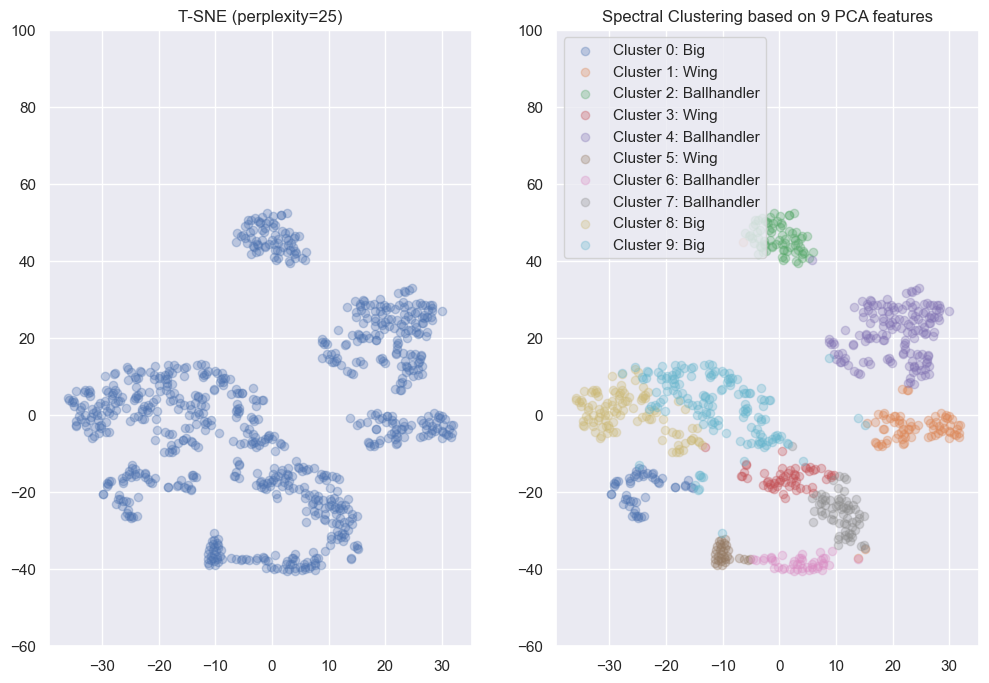

In [194]:
figsize(12, 8)

plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1], alpha=0.3)
plt.title(f'T-SNE (perplexity={perplexity})')
plt.ylim(lower_limit, upper_limit)

plt.subplot(1, 2, 2)
sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', 
                alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'Spectral Clustering based on {n_components} PCA features')

In [197]:
# figsize(12, 8)

# plt.subplot(1, 2, 1)
# for idx, pos in enumerate(['PG', 'SG', 'SF', 'PF', 'C'], 1):
#     pos_cond = df['pos'] == pos
#     pos_index = df[pos_cond].index
#     plt.scatter(X_tsne[pos_index, 0], 
#                 X_tsne[pos_index, 1], 
#                 label=pos, 
#                 alpha=0.3)
# plt.legend(loc=loc)
# plt.ylim(lower_limit, upper_limit)
# plt.title('Traditional Position Labels')

# plt.subplot(1, 2, 2)
# sc = SpectralClustering(n_clusters=n_clusters, 
#                         affinity='nearest_neighbors',
#                         random_state=42)
# labels = sc.fit_predict(X_transformed)
# for i in range(n_clusters):
#     cluster_index = [j for j in range(len(labels)) if labels[j] == i]
#     plt.scatter(X_tsne[cluster_index, 0], 
#                 X_tsne[cluster_index, 1], 
#                 label=f'Cluster {i}: {cluster_dict[i]}', 
#                 alpha=0.3)
# plt.legend(loc=loc)
# plt.ylim(lower_limit, upper_limit)
# plt.title(f'Spectral Clustering based on {n_components} PCA features')

In [199]:
# figsize(12, 8)

# plt.subplot(1, 2, 1)
# for i in range(n_clusters_tsne):
#     cluster_cond = df_tsne['cluster_label_tsne'] == i
#     cluster_index = df_tsne[cluster_cond].index
#     plt.scatter(X_tsne[cluster_index, 0], 
#                 X_tsne[cluster_index, 1], 
#                 label=f'Cluster {i}', 
#                 alpha=0.3)
# plt.legend(loc=loc)
# plt.ylim(lower_limit, upper_limit)
# plt.title('Spectral Clustering based on T-SNE')

# plt.subplot(1, 2, 2)
# sc = SpectralClustering(n_clusters=n_clusters, 
#                         affinity='nearest_neighbors',
#                         random_state=42)
# labels = sc.fit_predict(X_transformed)
# for i in range(n_clusters):
#     cluster_index = [j for j in range(len(labels)) if labels[j] == i]
#     plt.scatter(X_tsne[cluster_index, 0], 
#                 X_tsne[cluster_index, 1], 
#                 label=f'Cluster {i}: {cluster_dict[i]}', 
#                 alpha=0.3)
# plt.legend(loc=loc)
# plt.ylim(lower_limit, upper_limit)
# plt.title(f'Spectral Clustering based on {n_components} PCA features')

In [196]:
# figsize(12, 8)

# cluster_map_km_to_sc = {7: 0, 
#                         4: 1, 
#                         5: 2, 
#                         1: 3, 
#                         6: 4, 
#                         0: 5, 
#                         3: 6,
#                         2: 7}

# plt.subplot(1, 2, 1)
# sc = SpectralClustering(n_clusters=n_clusters, 
#                         affinity='nearest_neighbors',
#                         random_state=42)
# labels = sc.fit_predict(X_transformed)
# for i in range(n_clusters):
#     cluster_index = [j for j in range(len(labels)) if labels[j] == i]
#     plt.scatter(X_tsne[cluster_index, 0], 
#                 X_tsne[cluster_index, 1], 
#                 label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
# plt.legend(loc=loc)
# plt.ylim(lower_limit, upper_limit)
# plt.title(f'Spectral Clustering based on {n_components} PCA features\n')

# plt.subplot(1, 2, 2)
# km = KMeans(n_clusters=n_clusters, random_state=42)
# labels = km.fit_predict(X_transformed)
# labels = [cluster_map_km_to_sc[label] for label in labels]
# for i in range(n_clusters):
#     cluster_index = [j for j in range(len(labels)) if labels[j] == i]
#     plt.scatter(X_tsne[cluster_index, 0], 
#                 X_tsne[cluster_index, 1], 
#                 label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
# oos = '(Built for Out-of-Sample Predictions)'
# plt.title(f'K-Means based on {n_components} PCA features\n{oos}')
# plt.legend(loc=loc)
# plt.ylim(lower_limit, upper_limit)

## Save Models

In [68]:
# df.to_csv('nba_cleaned.csv', index=False)

In [69]:
# nba_clustering_models = {'pre_pca_pipe': pre_pca_pipe,
#                          'pca': pca,
#                          'pre_cluster_scaler': pre_cluster_scaler,
#                          'cluster_dict': cluster_dict}
# dump_pickle(nba_clustering_models, 'nba_clustering_models')

In [70]:
# cluster_map_km_to_sc = {7: 0, 
#                         4: 1, 
#                         5: 2, 
#                         1: 3, 
#                         6: 4, 
#                         0: 5, 
#                         3: 6,
#                         2: 7}
# nba_clustering_models_km = {'pre_pca_pipe': pre_pca_pipe,
#                             'pca': pca,
#                             'pre_cluster_scaler': pre_cluster_scaler,
#                             'cluster_map_to_spectral_clustering': cluster_map_km_to_sc,
#                             'km': km}
# dump_pickle(nba_clustering_models_km, 'nba_clustering_models_km')